In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_hsize_range'
)

num_genes = 16042
seed = 42

In [6]:
hsize_df = []

for gene_dir in glob.glob(os.path.join(results_dir, '*')):
    gene = os.path.basename(gene_dir)
    for results_file in glob.glob(
        os.path.join(
            results_dir,
            gene,
            f'{gene}_signal_mad_s{seed}_n{num_genes}_h*_classify_metrics.tsv.gz'
        )
    ):
        hsize = (
            os.path.basename(results_file).split('_')[5].replace('h', '')
        )
        hsize_gene_df = (
            pd.read_csv(results_file, sep='\t', index_col=0)
              .reset_index(drop=True)
              .drop(columns='holdout_cancer_type')
        )
        hsize_gene_df['hsize'] = hsize
        hsize_df.append(hsize_gene_df)

hsize_df = pd.concat(hsize_df)
print(np.sort(hsize_df.gene.unique()))
hsize_df.head()

['ABL1' 'ALK' 'APC' 'ARID1A' 'ARID1B' 'ARID2' 'ASXL1' 'ATM' 'ATRX' 'AXIN1'
 'BAP1' 'BCOR' 'BRAF' 'BRCA2' 'CARD11' 'CASP8' 'CDH1' 'CDKN2A' 'CIC'
 'CREBBP' 'CSF1R' 'CTNNB1' 'DNMT1' 'EGFR' 'EP300' 'ERBB2' 'EZH2' 'FBXW7'
 'FGFR2' 'FGFR3' 'FLT3' 'FOXL2' 'FUBP1' 'GATA2' 'GNAQ' 'GNAS' 'IDH1'
 'IDH2' 'JAK1' 'JAK2' 'KDM5C' 'KDM6A' 'KIT' 'KRAS' 'MED12' 'MET' 'NCOR1'
 'NF1' 'NF2' 'NFE2L2' 'NOTCH1' 'NOTCH2' 'NPM1' 'NRAS' 'PBRM1' 'PDGFRA'
 'PIK3CA' 'PTEN' 'RB1' 'RNF43' 'SETBP1' 'SETD2' 'SF3B1' 'SMAD2' 'SMAD4'
 'SMARCA4' 'SOX9' 'STAG2' 'STK11' 'TP53' 'VHL']


,aupr,gene,signal,seed,data_type,fold,hsize
0,0.98176,TP53,signal,42,train,0,4
1,0.88494,TP53,signal,42,test,0,4
2,0.87921,TP53,signal,42,cv,0,4
3,0.99779,TP53,signal,42,train,1,4
4,0.91229,TP53,signal,42,test,1,4


In [6]:
hsize_df = pd.concat(hsize_dfs.values())
print(hsize_df.shape)
hsize_df.head()

(24000, 6)


,epoch,fold,dataset,metric,value,hsize
0,1,0,train,aupr,0.468339,5
1,2,0,train,aupr,0.567901,5
2,3,0,train,aupr,0.592309,5
3,4,0,train,aupr,0.662504,5
4,5,0,train,aupr,0.663414,5


In [7]:
last_epoch = hsize_df.epoch.max()
perf_df = (hsize_df[hsize_df.epoch == last_epoch]
    .drop(columns=['epoch'])
)
                      
print(perf_df.shape)
perf_df.head()

(120, 5)


,fold,dataset,metric,value,hsize
199,0,train,aupr,0.937644,5
399,0,cv,aupr,0.775959,5
599,0,test,aupr,0.540191,5
799,1,train,aupr,0.985114,5
999,1,cv,aupr,0.761963,5


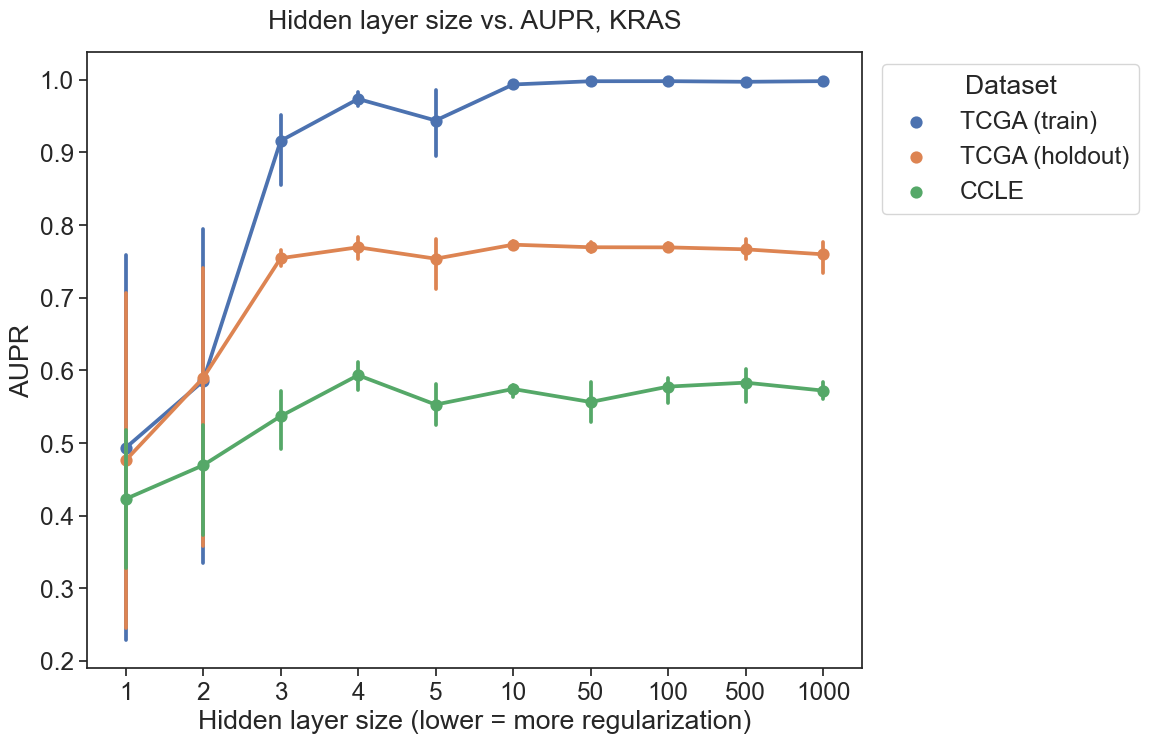

In [8]:
# plot hidden layer size as a categorical variable vs. performance
sns.set({'figure.figsize': (10, 8)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.pointplot(
        data=plot_df,
        x='hsize', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, {plot_gene}', y=1.025)

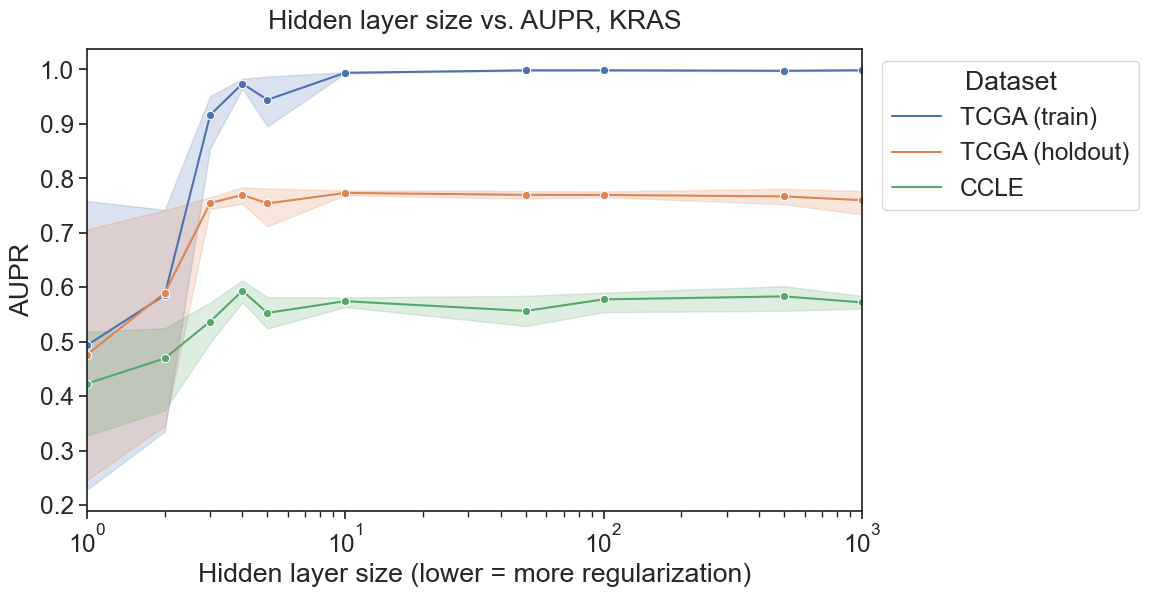

In [9]:
# plot hidden layer size as a float-valued variable (on a log scale) vs. performance
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='hsize', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.hsize), max(plot_df.hsize)))
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, {plot_gene}', y=1.025)